In [3]:
import numpy as np
import CHONK_XL as chxl
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
import xsimlab as xs
import CHONK_cpp as ch
import zarr
import helplotlib as hpl
# import helper as H
%matplotlib widget
%load_ext xsimlab.ipython
@xs.process
class CustomParameters:
	label_array = xs.variable(intent = 'in', dims = ('y','x'))
	label_list = xs.any_object()
	CHONK = xs.foreign(chxl.ChonkBase, "CHONK")
	nx = xs.foreign(chxl.ChonkBase, "nx")
	ny = xs.foreign(chxl.ChonkBase, "ny")
	dx = xs.foreign(chxl.ChonkBase, "dx")
	dy = xs.foreign(chxl.ChonkBase, "dy")
	
	active_nodes = xs.foreign(chxl.ChonkBase, "active_nodes")

	def initialize(self):

#		 self.landscape.add_pluton( dimless_X = 0.6, dimless_Y = 0.3, half_width = 5000,  half_heigth = 3000)
		self.label_list = []
	
		# self.label_array = self.landscape.indices

		self.label_list.append(ch.label(0))
		self.label_list[-1].m = 0.45;
		self.label_list[-1].n = 1;
		self.label_list[-1].base_K = 2e-5;
		self.label_list[-1].Ks_modifyer = 1.2;
		self.label_list[-1].Kr_modifyer = 0.8;
		self.label_list[-1].dimless_roughness = 0.5;
		self.label_list[-1].V = 0.5;
		self.label_list[-1].dstar = 1;
		self.label_list[-1].threshold_incision = 0;
		self.label_list[-1].threshold_entrainment = 0;
		self.label_list[-1].kappa_base = 1e-4;
		self.label_list[-1].kappa_r_mod = 0.8;
		self.label_list[-1].kappa_s_mod = 1.2;
		self.label_list[-1].critical_slope = 0.57835;
		self.label_list[-1].sensitivity_tool_effect = 1;

		self.label_list.append(ch.label(1))
		self.label_list[-1].m = 0.45;
		self.label_list[-1].n = 1;
		self.label_list[-1].base_K = 2e-5;
		self.label_list[-1].Ks_modifyer = 1;
		self.label_list[-1].Kr_modifyer = 0.3;
		self.label_list[-1].dimless_roughness = 0.5;
		self.label_list[-1].V = 0.1;
		self.label_list[-1].dstar = 1;
		self.label_list[-1].threshold_incision = 0;
		self.label_list[-1].threshold_entrainment = 0;
		self.label_list[-1].kappa_base = 1e-4;
		self.label_list[-1].kappa_r_mod = 0.8;
		self.label_list[-1].kappa_s_mod = 1.2;
		self.label_list[-1].critical_slope = 0.57835;
		self.label_list[-1].sensitivity_tool_effect = 1;

		self.CHONK.initialise_label_list(self.label_list)
		self.CHONK.update_label_array(self.label_array.ravel())


model = xs.Model({"ChonkBase": chxl.ChonkBase,
                "Runner": chxl.Runner,
                "Topography": chxl.Topography,
#                 "Uplift": UpliftLandscapeStSt,
#                 "Uplift": UpliftLandscape,
                # "Uplift": UpliftLandscapeNF1,
                "Uplift": chxl.Uplift,
                "Lake": chxl.Lake,
                "Precipitation": chxl.Precipitation,
#                 "DefaultParameters": chxl.DefaultParameters,
                "Params": CustomParameters,
                "Flow": chxl.Flow,
                "Fluvial": chxl.Fluvial,
                "Hillslope": chxl.Hillslope
            })

ny,nx = 200,3
dy,dx = 200,200
time = np.arange(0,2e7,1000)
otime = time[::100]

init_z = np.random.rand(ny,nx)
# U = np.zeros((ny,nx)) + 0.5e-3
# # U[0:round(ny/3),:] = 0
# # U[2 *round(ny/3):,:] = 0
# U[round(ny/2):,:] = 0
# U[0,:] = 0
init_z[0,:] = 1200

# init_z = np.load("SS_topolake.npy")


label_array = np.zeros((ny,nx), dtype = np.int32)
# label_array[40:80,40:80] = 1



label_array.shape


The xsimlab.ipython extension is already loaded. To reload it, use:
  %reload_ext xsimlab.ipython


(200, 3)

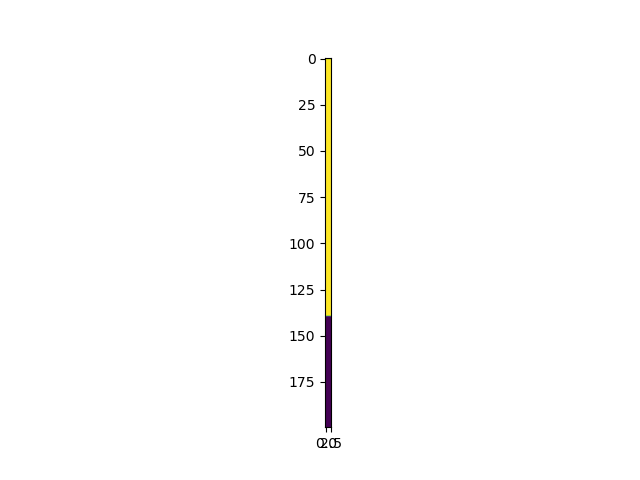

In [4]:
# Uplift shape
lU = np.zeros(ny)
lU[1:140] = 1
U = np.zeros((ny,nx))
for i in range(nx):
    U[:,i] = lU * 1e-3
# U[:,:] = lU * 1e-3
# U = np.rot90(U)[::-1]
fig, ax = plt.subplots()
ax.imshow(U)

In [5]:
# %create_setup model
# import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={
        "time":time,
        "otime":otime
    },
    master_clock="time",
    input_vars={
        'ChonkBase__dx': dx,
        'ChonkBase__dy': dy,
        'ChonkBase__nx': nx,
        'ChonkBase__ny': ny,
        'ChonkBase__boundary_conditions': "periodic_EW",
        'ChonkBase__depths_res_sed_proportions': 1,
        'ChonkBase__n_depth_sed_tracking': 50,
        'ChonkBase__strati_recorder': True,
        'ChonkBase__path_strati': "strati_lake",
        'ChonkBase__pref_strati': "test1",
        'ChonkBase__create_folder_strati': False,
        'Topography__initial_elevation': init_z,
        'Topography__initial_carving': True,
        'Uplift__uplift': U,
        'Lake__method': "implicit",
        'Lake__Aincision_threshold': False,
        'Lake__evaporation': False,
        'Lake__evaporation_rate': 1e-3,
        'Precipitation__precipitation_rate': 1,
        # 'Flow__threshold_single_flow': 1e12,
        'Flow__threshold_single_flow': 1e-12,
        'Params__label_array': label_array
    },
    output_vars=
    {
        'Topography__topography': 'otime',
        'Topography__sed_height': 'otime',
        'Flow__Qw': 'otime',
        'Flow__water_balance_checker': 'time',
        'Lake__lake_depth': 'otime',
        'Fluvial__Qs': 'otime',
        'Hillslope__Qs': 'otime',
        'ChonkBase__strati': 'otime'
    }
)

In [6]:
zg = zarr.group("SS_section_lake.zarr", overwrite=True)
with model,xs.monitoring.ProgressBar():
    out_ds = ds_in.xsimlab.run(store = zg)
#     out_ds = mod1.xsimlab.run()  
out_ds.x.values[0] = 0
out_ds.y.values[0] = 0

             0% | initialize 

In [7]:
from ipyfastscape import TopoViz3d


app = TopoViz3d(out_ds, canvas_height=600, time_dim="otime", elevation_var = "Topography__topography" )

app.show()

Output(layout=Layout(height='640px'))

In [ ]:
# np.save("SS_topolake.npy", out_ds.Topography__topography.values[-1])


